In [ ]:
##### import pickle
import pandas as pd
import numpy as np
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

from tqdm import tqdm
from matplotlib import colors
from pyproj import Proj

In [729]:
plt.style.use('dark_background')

In [730]:
H5_PATH = '/home/yang/output/eswe/imm/'
OUTPUT_PATH = '/home/yang/output/eswe/cls/'
EVENT = 'jkwh'
MACHINE_ID = '6088'
DATE = '072019'
FIELD_ID = 'f8'
log_name = '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-imm.h5'])

In [731]:
gps = pd.read_hdf(H5_PATH + log_name)

In [732]:
gps.head()

,machine_id,ts,lat,lon,alt,speed,track,accuracies,x,y,ts_local,cv_prob,nct_prob
0,Joe 6088,1297319691,40.779603,-102.323489,1156.000000,2.061553,13.8,5,725859.029481,4.517738e+06,2011-02-09 23:34:51,0.499834,0.500166
1,Joe 6088,1297319692,40.779624,-102.323562,1154.099976,1.500000,2.8,4,725852.777364,4.517741e+06,2011-02-09 23:34:52,0.550161,0.449839
2,Joe 6088,1297319693,40.779594,-102.323562,1146.000000,1.500000,2.7,3,725852.926930,4.517737e+06,2011-02-09 23:34:53,0.765277,0.234723
3,Joe 6088,1297319694,40.779619,-102.323589,1145.300049,1.500000,1.1,3,725850.556938,4.517740e+06,2011-02-09 23:34:54,0.991535,0.008465
4,Joe 6088,1563488097,40.778486,-102.325116,1144.599976,0.750000,92.6,3,725725.518647,4.517610e+06,2019-07-18 16:14:57,0.942039,0.057961


(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

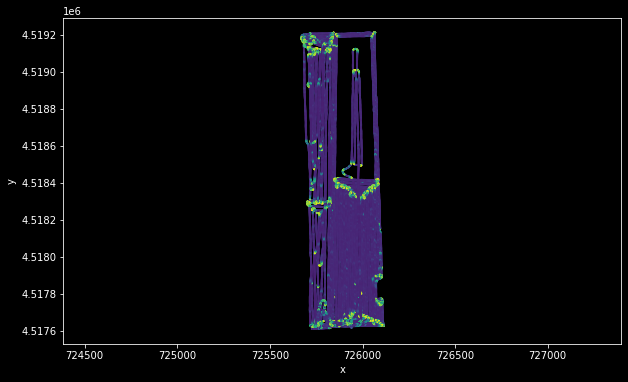

In [733]:
fig, ax = plt.subplots(figsize=(10,6))
gps.plot.scatter(x='x', y='y', c='nct_prob', s=1, cmap=plt.get_cmap('viridis'), colorbar=False, ax=ax)
ax.axis('equal')

In [734]:
# Obtain a copy of original df and assign `mode` to nans
# Available modes:
#     'w' - working
#     'nw-{x}' - non-working, specifically doing `x`
#                `x` can be 't' (turning), 'p' (parking), 's' (speeding)
gps_c = gps.copy()
gps_c['mode'] = np.nan

In [735]:
gps_c.loc[gps_c['nct_prob'] > 0.5, 'mode'] = 'nw-t'
gps_c.loc[gps_c['nct_prob'] <= 0.5, 'mode'] = 'w'

In [736]:
# Get the nonworking suspect points from any point that has NCT prob > 0.5
nw_susp = gps_c[gps_c['nct_prob'] > 0.5]

(725645.878431382, 726135.5144997414, 4517535.139508566, 4519290.726082066)

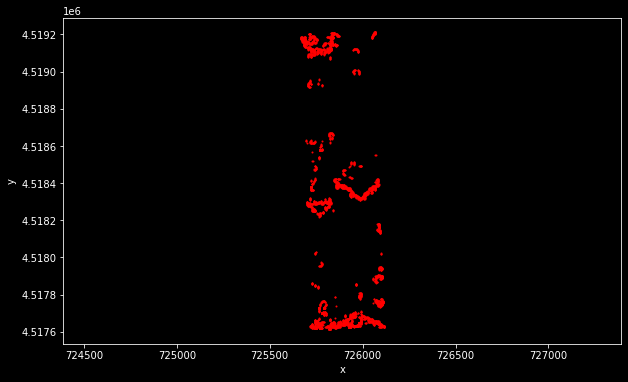

In [737]:
fig, ax = plt.subplots(figsize=(10,6))
nw_susp.plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
ax.axis('equal')

In [738]:
# Now let's group them using ST-DBSCAN
# Compute time distance
t_dist = squareform(pdist(nw_susp['ts'].values.reshape(len(nw_susp),1), metric='euclidean'))
# Compute coordinate distance
pt_dist = squareform(pdist(np.vstack([nw_susp['x'].values, nw_susp['y'].values]).T, metric='euclidean'))
# Make coordinate distance bigger when time are far apart
pt_dist_st = np.where(t_dist <= 10, pt_dist, 10*pt_dist)

In [739]:
# Now perform DBSCAN
c_stdbscan = DBSCAN(eps=5, min_samples=2, metric='precomputed').fit(pt_dist_st)

In [740]:
print(set(c_stdbscan.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [741]:
# Assign the cluster label onto the df
nw_susp_c = nw_susp.copy()
nw_susp_c['stdbscan_label'] = c_stdbscan.labels_

In [742]:
nw_susp_c['stdbscan_label'].value_counts()

230    1760
190     562
186     408
248     281
147     205
       ... 
80        2
47        2
4         2
237       2
136       2
Name: stdbscan_label, Length: 251, dtype: int64

(725645.878431382, 726135.5144997414, 4517535.139508566, 4519290.726082066)

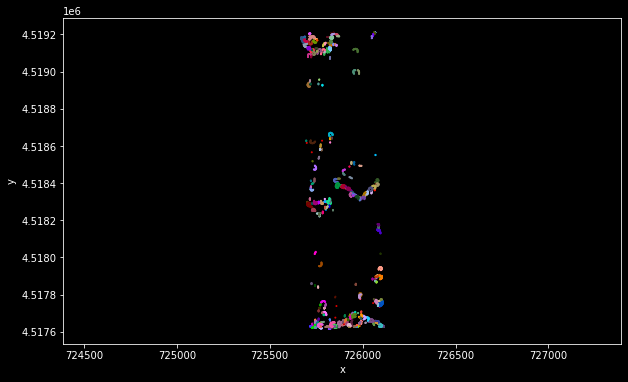

In [743]:
fig, ax = plt.subplots(figsize=(10,6))
nw_susp_c.plot.scatter(x='x', y='y', s=1, c='stdbscan_label', cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
ax.axis('equal')

In [744]:
# For noise labels, let's assume that they are valid working pts,
# so we will reassign these as working
gps_c.loc[nw_susp_c[nw_susp_c['stdbscan_label'] == -1].index, 'mode'] = 'w'

In [745]:
# Get an idea of speed mean for working points
print(gps_c.loc[gps_c['nct_prob'] <= 0.5, 'speed'].mean())

1.7650187934000128


In [746]:
# Let's look at the rest
stdbscan_labels = nw_susp_c['stdbscan_label'].unique().tolist()
if -1 in stdbscan_labels:
    stdbscan_labels.remove(-1)
# Use a number to keep track of actual non working points
nw_num = 0
for l in stdbscan_labels:
    tmp = nw_susp_c.loc[nw_susp_c['stdbscan_label'] == l, :]
#     print('Segment length: {} | Average speed: {:.2f} | Max track chg: {:.2f}'.format(\
#         len(tmp), tmp['speed'].mean(), \
#         np.nanmax(pdist(tmp['track'].values.reshape(len(tmp['track']),1), lambda u, v: (360-abs(u-v)) if (abs(u-v)) > 180 else abs(u-v)))))
    # If max heading chg > threshold then it is marked as turning
    if np.nanmax(pdist(tmp['track'].values.reshape(len(tmp['track']),1), lambda u, v: (360-abs(u-v)) if (abs(u-v)) > 180 else abs(u-v))) > 90:
        gps_c.loc[nw_susp_c[nw_susp_c['stdbscan_label'] == l].index, 'mode'] = 'nw-t'
        # We will label this as parking if the average speed < 0.10 m/s and the maximum distance traveled is less than 1 meter
        if (tmp['speed'].mean() < 0.10) & (np.nanmax(pdist(np.vstack([tmp['x'].values, tmp['y'].values]).T, metric='euclidean')) < 1):
            gps_c.loc[nw_susp_c[nw_susp_c['stdbscan_label'] == l].index, 'mode'] = 'nw-p'
        nw_num += 1
    else:
        gps_c.loc[nw_susp_c[nw_susp_c['stdbscan_label'] == l].index, 'mode'] = 'w'

(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

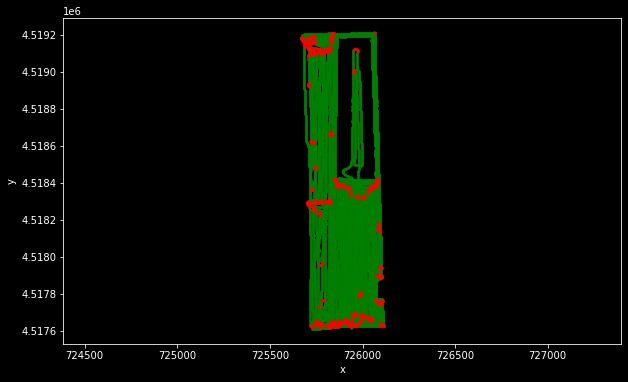

In [747]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
gps_c[gps_c['mode'] == 'w'].plot.scatter(x='x', y='y', s=1, c='g', ax=ax)
gps_c[gps_c['mode'] == 'nw-t'].plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
gps_c[gps_c['mode'] == 'nw-p'].plot.scatter(x='x', y='y', s=1, c='royalblue', ax=ax)
ax.axis('equal')

In [748]:
print(gps_c['speed'].mean(), gps_c['speed'].std(), gps_c['speed'].median())

1.5355223592216711 0.6569609423070617 1.75


In [749]:
gps_c.loc[(gps_c['mode'] == 'w') & (gps_c['speed'] < 0.10), 'mode'] = 'nw-p'
gps_c.loc[(gps_c['mode'] == 'w') & (gps_c['speed'] > gps_c['speed'].mean() + gps_c['speed'].std()), 'mode'] = 'nw-s'

(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

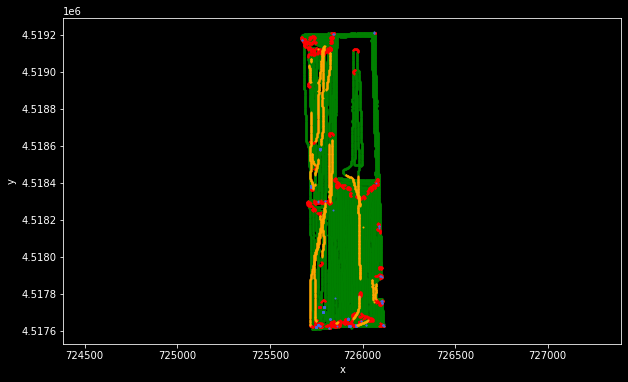

In [750]:
fig, ax = plt.subplots(figsize=(10,6))
gps_c[gps_c['mode'] == 'w'].plot.scatter(x='x', y='y', s=1, c='g', ax=ax)
gps_c[gps_c['mode'] == 'nw-t'].plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
gps_c[gps_c['mode'] == 'nw-p'].plot.scatter(x='x', y='y', s=1, c='royalblue', ax=ax)
gps_c[gps_c['mode'] == 'nw-s'].plot.scatter(x='x', y='y', s=1, c='orange', ax=ax)
ax.axis('equal')

In [751]:
# The non-working speeding group is still noisy, we need to use the same ST-DBSCAN trick to get rid of noise
nw_s_susp = gps_c[gps_c['mode'] == 'nw-s']

In [752]:
# Now let's group them using ST-DBSCAN
# Compute time distance
t_dist = squareform(pdist(nw_s_susp['ts'].values.reshape(len(nw_s_susp),1), metric='euclidean'))
# Compute coordinate distance
pt_dist = squareform(pdist(np.vstack([nw_s_susp['x'].values, nw_s_susp['y'].values]).T, metric='euclidean'))
# Make coordinate distance bigger when time are far apart
pt_dist_st = np.where(t_dist <= 10, pt_dist, 10*pt_dist)

In [753]:
# Now perform DBSCAN
c_stdbscan = DBSCAN(eps=5, min_samples=2, metric='precomputed').fit(pt_dist_st)

In [754]:
print(set(c_stdbscan.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}


In [755]:
nw_s_susp_c = nw_s_susp.copy()
nw_s_susp_c['stdbscan_label'] = c_stdbscan.labels_

(725693.9347855558, 726090.2136449604, 4517555.650084462, 4519216.110632984)

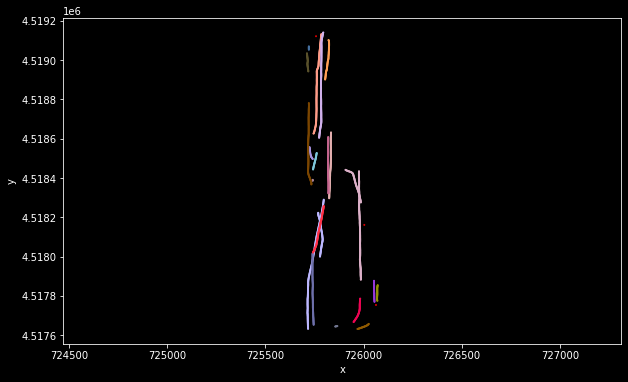

In [756]:
fig, ax = plt.subplots(figsize=(10,6))
nw_s_susp_c.plot.scatter(x='x', y='y', s=1, c='stdbscan_label', cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
ax.axis('equal')

In [757]:
# Reassign the noisy samples as working because they are simply too short
gps_c.loc[nw_s_susp_c[nw_s_susp_c['stdbscan_label'] == -1].index, 'mode'] = 'w' # TODO: this sometimes generate false 'working' points

In [758]:
# Let's look at the rest
stdbscan_labels = nw_s_susp_c['stdbscan_label'].unique().tolist()
if -1 in stdbscan_labels:
    stdbscan_labels.remove(-1)
# Use a number to keep track of actual non working points
nw_num = 0
for l in stdbscan_labels:
    tmp = nw_s_susp_c.loc[nw_s_susp_c['stdbscan_label'] == l, :]
    # If the segment has less than 10 samples, we mark this segment as working
    if len(tmp) < 5:
        gps_c.loc[nw_s_susp_c[nw_s_susp_c['stdbscan_label'] == l].index, 'mode'] = 'w'

(725645.8757153526, 726135.5715363597, 4517530.146109972, 4519291.243203093)

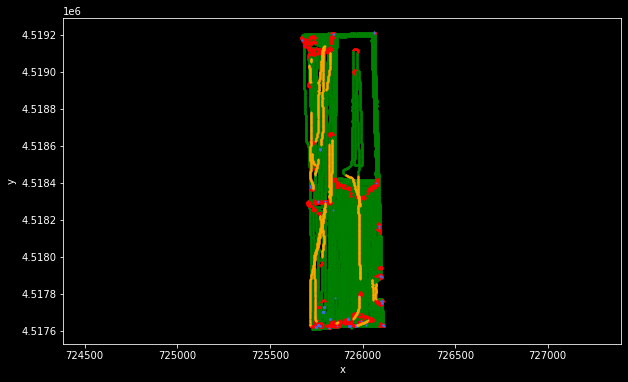

In [759]:
fig, ax = plt.subplots(figsize=(10,6))
gps_c[gps_c['mode'] == 'w'].plot.scatter(x='x', y='y', s=1, c='g', ax=ax)
gps_c[gps_c['mode'] == 'nw-t'].plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
gps_c[gps_c['mode'] == 'nw-p'].plot.scatter(x='x', y='y', s=1, c='royalblue', ax=ax)
gps_c[gps_c['mode'] == 'nw-s'].plot.scatter(x='x', y='y', s=1, c='orange', ax=ax)
ax.axis('equal')

In [760]:
gps_c.to_hdf(OUTPUT_PATH + '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-cls.h5']), \
             key='df', mode='w')